# How do I plot the results?
That is all too easy.
1. Load model parameters and metrics history.
2. Recreate the SET dataset. NOTE: It is crucial to save the seed and manipulations.
3. Use the function `generate_summary_plot`.

## Imports

In [7]:
import jax
import jax.numpy as jnp
from jax import random
from flax import linen as nn
from src.task import SETDataset
from src.model import EulerCTRNNCell
from src.training import create_train_state, MetricsHistory, ModelParameters
from src.analysis import generate_summary_plot

key = random.PRNGKey(0)

## Load model and metrics

In [2]:
features = 100
alpha = jnp.float32(1.0)
noise = jnp.float32(0.0)
ctrnn = nn.RNN(EulerCTRNNCell(features=features, alpha=alpha, noise=noise,))

key, subkey = random.split(key)
state = create_train_state(ctrnn, subkey, 0.001, 1.0)

In [3]:
save_loc = '../results/script_examples/params.bin'
model_params = ModelParameters(state)
model_params.deserialize(save_loc,)

In [4]:
metrics_history = MetricsHistory([
    'train_loss', 'train_accuracy',
    'test_loss', 'test_accuracy',
    'grok_loss', 'grok_accuracy',
    'corrupt_loss', 'corrupt_accuracy',
])

save_loc = '../results/script_examples/metrics_history.csv'
metrics_history.load_from_csv(save_loc)

## Recreate SET dataset

In [8]:
key = random.PRNGKey(0)
key, subkey = random.split(key)
set_dataset = SETDataset(subkey, 30, 5, 128)
#set_dataset.grok_SET(2)
#set_dataset.corrupt_SET(3)
set_dataset.print_training_testing()
training_tf_dataset, testing_tf_dataset, grok_tf_dataset, corrupt_tf_dataset = set_dataset.tf_datasets()


TRAINING DATA

Accepting Grid:
SET_combinations | Number of Trials | Status
GGG | 60 | 
GPR | 60 | 
GRP | 60 | 
PGR | 60 | 
PPP | 60 | 
PRG | 60 | 
RGP | 60 | 
RPG | 60 | 
RRR | 60 | 

Rejecting Grid:
SET_combinations | Number of Trials | Status
GGP | 30 | 
GGR | 30 | 
GPG | 30 | 
GPP | 30 | 
GRG | 30 | 
GRR | 30 | 
PGG | 30 | 
PGP | 30 | 
PPG | 30 | 
PPR | 30 | 
PRP | 30 | 
PRR | 30 | 
RGG | 30 | 
RGR | 30 | 
RPP | 30 | 
RPR | 30 | 
RRG | 30 | 
RRP | 30 | 

----------

TESTING DATA

Accepting Grid:
SET_combinations | Number of Trials | Status
GGG | 5 | 
GPR | 5 | 
GRP | 5 | 
PGR | 5 | 
PPP | 5 | 
PRG | 5 | 
RGP | 5 | 
RPG | 5 | 
RRR | 5 | 

Rejecting Grid:
SET_combinations | Number of Trials | Status
GGP | 5 | 
GGR | 5 | 
GPG | 5 | 
GPP | 5 | 
GRG | 5 | 
GRR | 5 | 
PGG | 5 | 
PGP | 5 | 
PPG | 5 | 
PPR | 5 | 
PRP | 5 | 
PRR | 5 | 
RGG | 5 | 
RGR | 5 | 
RPP | 5 | 
RPR | 5 | 
RRG | 5 | 
RRP | 5 | 

----------

GROK DATA

Accepting Grid:
SET_combinations | Number of Trials | Status

Reje

## Generate summary plot

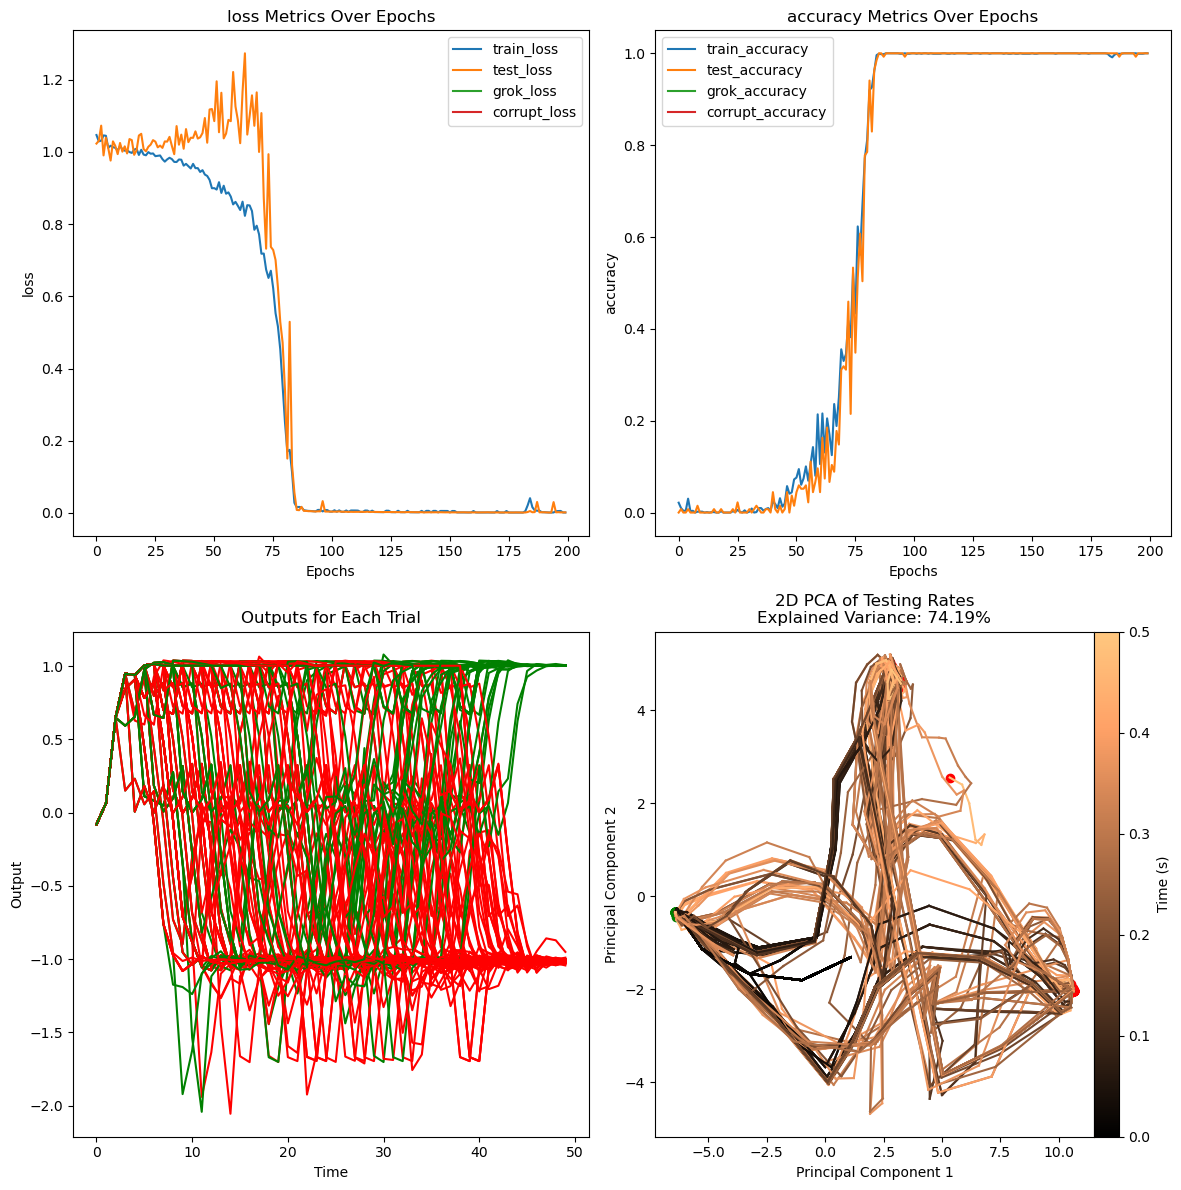

In [6]:
save_loc = '../results/script_examples/summary_plot.jpg'
key, subkey = random.split(key)
generate_summary_plot(
    subkey, 
    ctrnn, 
    model_params.params, 
    metrics_history.history, 
    training_tf_dataset, 
    testing_tf_dataset, save_loc)